# Unit 4 Capstone - Classifying classic authors by word usage

For this project you'll dig into a large amount of text and apply most of what you've covered in this unit and in the course so far.

First, pick a set of texts. This can be either a series of novels, chapters, or articles. Anything you'd like. It just has to have multiple entries of varying characteristics. At least 100 should be good. There should also be at least 10 different authors, but try to keep the texts related (either all on the same topic of from the same branch of literature - something to make classification a bit more difficult than obviously different subjects).

This capstone can be an extension of your NLP challenge if you wish to use the same corpus. If you found problems with that data set that limited your analysis, however, it may be worth using what you learned to choose a new corpus. Reserve 25% of your corpus as a test set.

The first technique is to create a series of clusters. Try several techniques and pick the one you think best represents your data. Make sure there is a narrative and reasoning around why you have chosen the given clusters. Are authors consistently grouped into the same cluster?

Next, perform some unsupervised feature generation and selection using the techniques covered in this unit and elsewhere in the course. Using those features then build models to attempt to classify your texts by author. Try different permutations of unsupervised and supervised techniques to see which combinations have the best performance.

Lastly return to your holdout group. Does your clustering on those members perform as you'd expect? Have your clusters remained stable or changed dramatically? What about your model? Is it's performance consistent?

If there is a divergence in the relative stability of your model and your clusters, delve into why.

Your end result should be a write up of how clustering and modeling compare for classifying your texts. What are the advantages of each? Why would you want to use one over the other? Approximately 3-5 pages is a good length for your write up, and remember to include visuals to help tell your story!

## Load Data

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import gutenberg, stopwords
from collections import Counter
import nltk

In [2]:
# get list of texts to load
print(gutenberg.fileids())

['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt', 'bible-kjv.txt', 'blake-poems.txt', 'bryant-stories.txt', 'burgess-busterbrown.txt', 'carroll-alice.txt', 'chesterton-ball.txt', 'chesterton-brown.txt', 'chesterton-thursday.txt', 'edgeworth-parents.txt', 'melville-moby_dick.txt', 'milton-paradise.txt', 'shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt', 'whitman-leaves.txt']


In [3]:
# Utility function for standard text cleaning.
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    return text
# load first 5000 characters from ten books by different authors as tuple
austen = gutenberg.raw('austen-emma.txt')[0:100000]
edgeworth = gutenberg.raw('edgeworth-parents.txt')[0:100000]
blake = gutenberg.raw('blake-poems.txt')[0:100000]
bryant = gutenberg.raw('bryant-stories.txt')[0:100000]
burgess = gutenberg.raw('burgess-busterbrown.txt')[0:100000]
carroll = gutenberg.raw('carroll-alice.txt')[0:100000]
chesterton = gutenberg.raw('chesterton-ball.txt')[0:100000]
melville = gutenberg.raw('melville-moby_dick.txt')[0:100000]
milton = gutenberg.raw('milton-paradise.txt')[0:100000]
shakespeare = gutenberg.raw('shakespeare-caesar.txt')[0:100000]
# clean text
austen = text_cleaner(austen)
edgeworth = text_cleaner(edgeworth)
blake = text_cleaner(blake)
bryant = text_cleaner(bryant)
burgess = text_cleaner(burgess)
carroll = text_cleaner(carroll)
chesterton = text_cleaner(chesterton)
melville = text_cleaner(melville)
milton = text_cleaner(milton)
shakespeare = text_cleaner(shakespeare)
# remove chapter and volume headings
austen = re.sub(r'CHAPTER \d+', '', austen)
austen = re.sub(r'VOLUME \d+', '', austen)
edgeworth = re.sub(r'Chapter \d+', '', edgeworth)
blake = re.sub(r'Chapter \d+', '', blake)
bryant = re.sub(r'Chapter \d+', '', bryant)
burgess = re.sub(r'Chapter \d+', '', burgess)
carroll = re.sub(r'Chapter \d+', '', carroll)
chesterton = re.sub(r'Chapter \d+', '', chesterton)
melville = re.sub(r'Chapter \d+', '', melville)
milton = re.sub(r'Chapter \d+', '', milton)
shakespeare = re.sub(r'Chapter \d+', '', shakespeare)
# load spacy
nlp = spacy.load('en')
# load ten sentences from each doc author
austen_doc = nlp(austen)
edgeworth_doc = nlp(edgeworth)
blake_doc = nlp(blake)
bryant_doc = nlp(bryant)
burgess_doc = nlp(burgess)
carroll_doc = nlp(carroll)
chesterton_doc = nlp(chesterton)
melville_doc = nlp(melville)
milton_doc = nlp(milton)
shakespeare_doc = nlp(shakespeare)

In [4]:
# Utility function to create a list of the 2000 most common words.
def bag_of_words(text):
    
    # Filter out punctuation and stop words.
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    
    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(2000)]
    

# Creates a data frame with features for each word in our common word set.
# Each value is the count of the times the word appears in each sentence.
def bow_features(sentences, common_words):
    
    # Scaffold the data frame and initialize counts to zero.
    df = pd.DataFrame(columns=common_words)
    df['text_sentence'] = sentences[0]
    df['text_source'] = sentences[1]
    df.loc[:, common_words] = 0
    
    # Process each row, counting the occurrence of words in each sentence.
    for i, sentence in enumerate(df['text_sentence'][::100]):
        
        # Convert the sentence to lemmas, then filter out punctuation,
        # stop words, and uncommon words.
        words = [token.lemma_
                 for token in sentence
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in common_words
                 )]
        
        # Populate the row with word counts.
        for word in words:
            df.loc[i, word] += 1
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 50 == 0:
            print("Processing row {}".format(i))
            
    return df

# Set up the bags.
austenwords = bag_of_words(austen_doc)
edgeworthwords = bag_of_words(edgeworth_doc)
blakewords = bag_of_words(blake_doc)
bryantwords = bag_of_words(bryant_doc)
burgesswords = bag_of_words(burgess_doc)
carrollwords = bag_of_words(carroll_doc)
chestertonwords = bag_of_words(chesterton_doc)
melvillewords = bag_of_words(melville_doc)
miltonwords = bag_of_words(milton_doc)
shakespearewords = bag_of_words(shakespeare_doc)

# Combine bags to create a set of unique words.
common_words = set(austenwords + edgeworthwords + blakewords + bryantwords + burgesswords + carrollwords + 
                   chestertonwords + melvillewords + miltonwords + shakespearewords)

In [5]:
# Group into sentences.
austen_sents = [[sent, 'Austen'] for sent in austen_doc.sents]
edgeworth_sents = [[sent, 'Edgeworth'] for sent in edgeworth_doc.sents]
blake_sents = [[sent, 'Blake'] for sent in blake_doc.sents]
bryant_sents = [[sent, 'Bryant'] for sent in bryant_doc.sents]
burgess_sents = [[sent, 'Burgess'] for sent in burgess_doc.sents]
carroll_sents = [[sent, 'Carroll'] for sent in carroll_doc.sents]
chesterton_sents = [[sent, 'Chesterton'] for sent in chesterton_doc.sents]
melville_sents = [[sent, 'Melville'] for sent in melville_doc.sents]
milton_sents = [[sent, 'Milton'] for sent in milton_doc.sents]
shakespeare_sents = [[sent, 'Shakespeare'] for sent in shakespeare_doc.sents]

# Combine the sentences from the two novels into one data frame.
sentences = pd.DataFrame(austen_sents + edgeworth_sents + blake_sents + bryant_sents + burgess_sents + carroll_sents
                         + chesterton_sents + melville_sents + milton_sents + shakespeare_sents)
sentences.head()

,0,1
0,"(VOLUME, I, CHAPTER)",Austen
1,(I),Austen
2,"(Emma, Woodhouse, ,, handsome, ,, clever, ,, a...",Austen
3,"(She, was, the, youngest, of, the, two, daught...",Austen
4,"(Her, mother, had, died, too, long, ago, for, ...",Austen


In [6]:
# Create our data frame with features
word_counts = bow_features(sentences, common_words)
word_counts.head()

Processing row 0
Processing row 50
Processing row 100


,wood,freeze,concord,intelligent,johnny,xiii,faile,tie,mazy,scalding,...,flannel,so,summon,peers,hasten,traitors,drizzle,africa,text_sentence,text_source
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(VOLUME, I, CHAPTER)",Austen
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,(I),Austen
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Emma, Woodhouse, ,, handsome, ,, clever, ,, a...",Austen
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(She, was, the, youngest, of, the, two, daught...",Austen
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Her, mother, had, died, too, long, ago, for, ...",Austen


And lastly the training and holdout groups will be created. 

In [7]:
# shuffle data before split
word_counts = word_counts.sample(frac=1)
# holdout
holdout = word_counts[:int(len(word_counts)/4)]
# redeclare train group
word_counts = word_counts[int(len(word_counts)/4):]

# Clustering

## Means Shift

In [8]:
# run means shift clustering
X = word_counts.drop(['text_sentence', 'text_source'], 1)
from sklearn.cluster import MeanShift, estimate_bandwidth
band = estimate_bandwidth(X, quantile=0.75)
ms = MeanShift(bandwidth=band, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)
print('Means shift found {} clusters in the data'.format(len(labels_unique)))

Means shift found 76 clusters in the data


Means shift clustering seems more reliable than affinity propogation in this case becasue it can tell the model to set its own bandwith, and it does not overstimate the number of clusters. 

## Affinity Propogation

In [9]:
# run affinity propogation
from sklearn.cluster import AffinityPropagation
clustering = AffinityPropagation().fit(X)
AffinityPropagation(affinity='euclidean', convergence_iter=15, copy=True,
          damping=0.5, max_iter=200, preference=None, verbose=False)
print('Affinity propogation found {} clusters in the data'.format(len(clustering.labels_)))

Affinity propogation found 7638 clusters in the data


Affinity propogation tends to overestimate the number of clusters in a dataset, which is true here. Also, affinity propogation works to find linkages between datapoints. Since the bow_features function produces thousands of binary columns for common words, the model likely severly overestimated the number of clusters in the data. 

# Unsupervised feature generation and selection with tfidf

tfidf will be used to vectorize the words in each sentence in the word_counts frame.

In [10]:
# import vactorizer and set parameters
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_df=0.75, # drop words that occur in more than three quarters the paragraphs
                             min_df=5, # only use words that appear at least 5 times
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

In [11]:
# create function to list tfidf scores by word by author training frame
def get_features(author):
    # get dataframe of words, tfidf scores and author
    df_text = word_counts[word_counts['text_source']==author]
    # convert text to string so tfidf works on spacy text
    text = ','.join(str(x) for x in df_text['text_sentence'])
    # make list for tfidf
    text = [text]
    # run vectorizer
    vect = TfidfVectorizer()
    tfidf_matrix = vect.fit_transform(text)
    df = pd.DataFrame(tfidf_matrix.toarray(), columns = vect.get_feature_names())
    # transpose data 
    df = df.T
    # create response columns
    df['author'] = '{}'.format(author)
    df.reset_index(level=0, inplace=True)
    df = df.rename(columns={'index': 'word', 0: 'tfidf_score'})
    model = pd.DataFrame()
    model = model.append(df)
    return model

In [12]:
# get data for all authors and append dataframes
Blake = get_features('Blake')
Austen = get_features('Austen')
Bryant = get_features('Bryant')
Burgess = get_features('Burgess')
Carroll = get_features('Carroll')
Chesterton = get_features('Chesterton')
Edgeworth = get_features('Edgeworth')
Melville = get_features('Melville')
Milton = get_features('Milton')
Shakespeare = get_features('Shakespeare')
# combine frames into one frame for modeling
df_model = Blake.append([Austen, Bryant, Burgess, Carroll, Chesterton, Edgeworth, Melville, Milton, Shakespeare])
df_model.head()

,word,tfidf_score,author
0,1780,0.002053,Blake
1,abroad,0.002053,Blake
2,abstract,0.002053,Blake
3,ache,0.002053,Blake
4,afar,0.002053,Blake


Now the word column will be used to create categorical variables for each word. This will allow the assignment of numerical values to each word that can then be used in machine learning models.  

In [13]:
# convert series to category dtype so cat.codes works
df_model['word'] = df_model['word'].astype('category')
# create dictionary of values to words in case the words need to be found again
word_dict = dict( enumerate(df_model['word'].cat.categories) )
# convert word column to catgegorical variables
df_model['word'] = df_model['word'].cat.codes
df_model.head()

,word,tfidf_score,author
0,9,0.002053,Blake
1,102,0.002053,Blake
2,110,0.002053,Blake
3,146,0.002053,Blake
4,223,0.002053,Blake


# Machine learning to predict author - H2O Flow

In [14]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,4 hours 8 mins
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.6
H2O cluster version age:,4 days
H2O cluster name:,H2O_from_python_kyleknoebel_g50r14
H2O cluster total nodes:,1
H2O cluster free memory:,1.261 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


## Unsupervised - Neural network

In [15]:
# shuffle data 
df_model = df_model.sample(frac=1)
# create dataframe for H2O
df_h2o_model= h2o.H2OFrame(df_model)
# create training, test, validation frames
train,test,valid = df_h2o_model.split_frame(ratios = [0.75, 0.15])
# import deep learning estimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
# create response and training variables
x = ['word', 'tfidf_score']
y = 'author'
# deep learning parameters
nn_model = H2ODeepLearningEstimator(hidden=[2, 2], epochs=100, seed=1234)
nn_model.train(x=x, y=y, training_frame=train, validation_frame=valid)
# show accuracy
nn_model._model_json['output']['scoring_history'].as_data_frame()

Parse progress: |█████████████████████████████████████████████████████████| 100%
deeplearning Model Build progress: |██████████████████████████████████████| 100%


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_r2,training_classification_error,validation_rmse,validation_logloss,validation_r2,validation_classification_error
0,,2019-03-18 20:02:35,0.000 sec,None,0.000000,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2019-03-18 20:02:35,0.220 sec,719690 obs/sec,6.060645,1,100037.0,0.888103,2.236034,0.903265,0.844671,0.888952,2.244737,0.902019,0.845402
2,,2019-03-18 20:02:36,1.950 sec,921016 obs/sec,102.948928,17,1699275.0,0.882517,2.182736,0.904478,0.844671,0.883044,2.187973,0.903317,0.845402


## Supervised - Random forest

In [16]:
# import model
from h2o.estimators.random_forest import H2ORandomForestEstimator
# deep learning parameters
rf_model = H2ORandomForestEstimator(ntrees=200, stopping_rounds=2, seed=1234)
rf_model.train(x=x, y=y, training_frame=train, validation_frame=valid)
# show accuracy
rf_model._model_json['output']['scoring_history'].as_data_frame()

drf Model Build progress: |███████████████████████████████████████████████| 100%


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_classification_error,validation_rmse,validation_logloss,validation_classification_error
0,,2019-03-18 20:02:37,0.003 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,,2019-03-18 20:02:37,0.106 sec,1.0,0.513570,7.668502,0.271107,0.529597,8.038819,0.302532
2,,2019-03-18 20:02:37,0.167 sec,2.0,0.438099,5.463474,0.196340,0.385955,3.431103,0.152821
3,,2019-03-18 20:02:37,0.234 sec,3.0,0.404718,4.500523,0.167690,0.354070,2.297694,0.126166
4,,2019-03-18 20:02:37,0.311 sec,4.0,0.400518,4.226616,0.163716,0.356834,2.065236,0.126610
5,,2019-03-18 20:02:37,0.389 sec,5.0,0.397720,3.984169,0.162863,0.356790,1.882607,0.124389
6,,2019-03-18 20:02:37,0.470 sec,6.0,0.383646,3.524920,0.151394,0.347686,1.641514,0.113727
7,,2019-03-18 20:02:37,0.554 sec,7.0,0.373304,3.184186,0.141696,0.342813,1.478276,0.108841
8,,2019-03-18 20:02:37,0.649 sec,8.0,0.369670,2.973683,0.138407,0.342691,1.394646,0.107952
9,,2019-03-18 20:02:38,0.745 sec,9.0,0.358817,2.660778,0.130153,0.332994,1.273919,0.103065


# Holdout testing

In [17]:
# create function for holdout group 
def get_features(author):
    # get dataframe of words, tfidf scores and author
    df_text = holdout[holdout['text_source']==author]
    text = ','.join(str(x) for x in df_text['text_sentence'])
    text = [text]
    vect = TfidfVectorizer()
    tfidf_matrix = vect.fit_transform(text)
    df = pd.DataFrame(tfidf_matrix.toarray(), columns = vect.get_feature_names())
    df = df.T
    df['author'] = '{}'.format(author)
    df.reset_index(level=0, inplace=True)
    df = df.rename(columns={'index': 'word', 0: 'tfidf_score'})
    model = pd.DataFrame()
    model = model.append(df)
    return model
# get data for all authors and append dataframes
Blake = get_features('Blake')
Austen = get_features('Austen')
Bryant = get_features('Bryant')
Burgess = get_features('Burgess')
Carroll = get_features('Carroll')
Chesterton = get_features('Chesterton')
Edgeworth = get_features('Edgeworth')
Melville = get_features('Melville')
Milton = get_features('Milton')
Shakespeare = get_features('Shakespeare')
df_holdout = Blake.append([Austen, Bryant, Burgess, Carroll, Chesterton, Edgeworth, Melville, Milton, Shakespeare])
df_holdout.head()

,word,tfidf_score,author
0,about,0.005308,Blake
1,admired,0.005308,Blake
2,adona,0.005308,Blake
3,affright,0.005308,Blake
4,against,0.005308,Blake


## Clustering

In [18]:
# run means shift on holdout frame
X = holdout.drop(['text_sentence', 'text_source'], 1)
from sklearn.cluster import MeanShift, estimate_bandwidth
band = estimate_bandwidth(X, quantile=0.75)
ms = MeanShift(bandwidth=band, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)
print('Means shift found {} clusters in the data'.format(len(labels_unique)))

Means shift found 22 clusters in the data


In [19]:
# run affinity propogation
from sklearn.cluster import AffinityPropagation
clustering = AffinityPropagation().fit(X)
AffinityPropagation(affinity='euclidean', convergence_iter=15, copy=True,
          damping=0.5, max_iter=200, preference=None, verbose=False)
print('Affinity propogation found {} clusters in the data'.format(len(clustering.labels_)))

Affinity propogation found 2546 clusters in the data


## Neural network

In [20]:
# shuffle data 
df_holdout = df_holdout.sample(frac=1)
# create dataframe for H2O
df_h2o_model_holdout= h2o.H2OFrame(df_holdout)
# create training, test, validation frames
train_h,test_h,valid_h = df_h2o_model_holdout.split_frame(ratios = [0.75, 0.15])
# create response and training variables
x = ['word', 'tfidf_score']
y = 'author'
# deep learning parameters
nn_model_h = H2ODeepLearningEstimator(hidden=[2, 2], epochs=100, seed=1234)
nn_model_h.train(x=x, y=y, training_frame=train_h, validation_frame=valid_h)
# show accuracy
nn_model_h._model_json['output']['scoring_history'].as_data_frame()

Parse progress: |█████████████████████████████████████████████████████████| 100%
deeplearning Model Build progress: |██████████████████████████████████████| 100%


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_r2,training_classification_error,validation_rmse,validation_logloss,validation_r2,validation_classification_error
0,,2019-03-18 20:03:09,0.000 sec,None,0.000000,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2019-03-18 20:03:09,0.130 sec,192222 obs/sec,0.401578,1,3460.0,0.887166,2.569062,0.903228,0.860608,0.887862,2.582324,0.901148,0.859867
2,,2019-03-18 20:03:14,5.147 sec,136454 obs/sec,78.236305,191,674084.0,0.894950,2.392631,0.901522,0.859448,0.898833,2.422272,0.898690,0.878109
3,,2019-03-18 20:03:15,6.729 sec,134690 obs/sec,100.408310,245,865118.0,0.896959,2.433828,0.901079,0.908890,0.894628,2.407989,0.899635,0.903814


## Random forest

In [21]:
# deep learning parameters
rf_model_h = H2ORandomForestEstimator(ntrees=200, stopping_rounds=2, seed=1234)
rf_model_h.train(x=x, y=y, training_frame=train_h, validation_frame=valid_h)
# show accuracy
rf_model_h._model_json['output']['scoring_history'].as_data_frame()

drf Model Build progress: |███████████████████████████████████████████████| 100%


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_classification_error,validation_rmse,validation_logloss,validation_classification_error
0,,2019-03-18 20:03:16,0.023 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,,2019-03-18 20:03:16,0.117 sec,1.0,0.612213,12.228297,0.355035,0.626379,12.680359,0.397181
2,,2019-03-18 20:03:16,0.154 sec,2.0,0.506486,8.307597,0.250291,0.405501,4.678126,0.170813
3,,2019-03-18 20:03:16,0.191 sec,3.0,0.441045,6.074987,0.193444,0.339030,2.649073,0.120232
4,,2019-03-18 20:03:16,0.245 sec,4.0,0.421699,5.335349,0.178799,0.336118,2.256579,0.116086
5,,2019-03-18 20:03:16,0.318 sec,5.0,0.418647,5.102575,0.177760,0.337905,2.027977,0.117745
6,,2019-03-18 20:03:17,0.376 sec,6.0,0.397057,4.372776,0.158025,0.329788,1.706817,0.109453
7,,2019-03-18 20:03:17,0.427 sec,7.0,0.377551,3.718919,0.143737,0.320569,1.452873,0.102819
8,,2019-03-18 20:03:17,0.484 sec,8.0,0.369709,3.451601,0.137274,0.322780,1.429145,0.101990
9,,2019-03-18 20:03:17,0.540 sec,9.0,0.356990,3.065563,0.127815,0.318121,1.318139,0.097844


# Summary

## Clustering

There is divergence in the results of the means shift method between the holdout and training group. Since the holdout group is a random sampling of the whole dataframe, only certain words from the BOW model will carry through to the holdout group. So even if all authors are in the holdout, not all the words will be which is likely the reason for the fewer amount of clusters. 

The same logic pertains to the affinity propogation algorithm. While the affinity propogation model overestimates the number of clusters, something interesting happens when you look at the difference in the number of clusters in the two methods: 

In [27]:
# show percentage of clusters in holdout compared to train for each model
print('The means shift holdout clusters are {}% of the training frame'.format((22/76)*100))
print('The affinity propogation holdout clusters are {}% of the training frame'.format((2546/7638)*100))

The means shift holdout clusters are 28.947368421052634% of the training frame
The affinity propogation holdout clusters are 33.33333333333333% of the training frame


The similarity in cluster groupings between each method show that the algorithms are finding simliar cluster structure between the frames. The fact that the groupings follow a similar pattern show that authors are consistently grouped into the same clusters. Means shift is the better option on this data as it does not overestimate the number of clusters. 

## Neural network

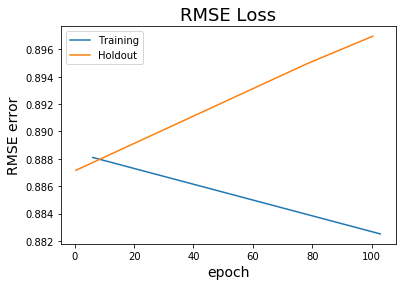

In [23]:
# declare scoring histories
scoring_history_t = nn_model.score_history()
scoring_history_h = nn_model_h.score_history()
# plot the loss for train and holdout frames 
plt.plot(scoring_history_t['epochs'], scoring_history_t['training_rmse']) 
plt.plot(scoring_history_h['epochs'], scoring_history_h['training_rmse']) 
labels = ['Training', 'Holdout']
plt.title('RMSE Loss', fontsize=18)
plt.ylabel('RMSE error', fontsize=14)
plt.xlabel('epoch', fontsize=14)
plt.legend(labels, loc='best')
plt.show()

The divergence in the loss of the holdout and training RMSE error shows that this model is not stable. 

## Random forest

In [24]:
# training
rf_model.predict(valid)

drf prediction progress: |████████████████████████████████████████████████| 100%


predict,Austen,Blake,Bryant,Burgess,Carroll,Chesterton,Edgeworth,Melville,Milton,Shakespeare
Austen,1,0,0,0,0,0,0,0,0,0
Melville,0,0,0,0.00112994,0,0,0,0.99887,0,0
Shakespeare,0,0,0.0177187,0,0,0,0,0,0,0.982281
Bryant,0,0,0.998693,0,0.00130726,0,0,0,0,0
Shakespeare,0.0380183,0.000258628,0,0,0,0,0,0,0,0.961723
Melville,0,0,0,0.0369532,0.00226244,0,0,0.960784,0,0
Chesterton,0.083952,0.111936,0.125912,0,0,0.622232,0.055968,0,0,0
Burgess,0,0,0,1,0,0,0,0,0,0
Melville,0,0,0.012633,0,0.00199468,0,0,0.985372,0,0
Chesterton,0.00387918,0,0.00258672,0,0,0.993534,0,0,0,0


In [25]:
# holdout
rf_model_h.predict(valid_h)

drf prediction progress: |████████████████████████████████████████████████| 100%


predict,Austen,Blake,Bryant,Burgess,Carroll,Chesterton,Edgeworth,Melville,Milton,Shakespeare
Edgeworth,0,0,0,0,0,0,1,0,0,0
Melville,0.0381679,0,0,0.0458015,0,0,0,0.916031,0,0
Bryant,0,0,0.861111,0,0.111111,0.0277778,0,0,0,0
Burgess,0,0,0.0229695,0.651308,0.138128,0,0.100455,0.0840652,0.00154653,0.00152724
Bryant,0.030303,0,0.939394,0,0.030303,0,0,0,0,0
Shakespeare,0.0145743,0.00754817,0.00324075,0.0441421,0.0161117,0.0112404,0.0235792,0.128082,0.0737111,0.677771
Shakespeare,0.0607303,0.246589,0.109245,0.240757,0.00566488,0,0.0332006,0,0.00751463,0.296298
Burgess,0,0,0,1,0,0,0,0,0,0
Edgeworth,0,0,0.0967742,0,0,0,0.903226,0,0,0
Edgeworth,0,0,0,0,0,0,1,0,0,0


The tables above show the accuracy and error of the random forest model when classifiying authors in the validation frame. While the tables show some error in the model, they also could be used to show which authors use similar words. 

Overall, the model shows relatively good accuracy when classifiying authors. Furthermore, the random forest shows much less classification error than the neural network model. 

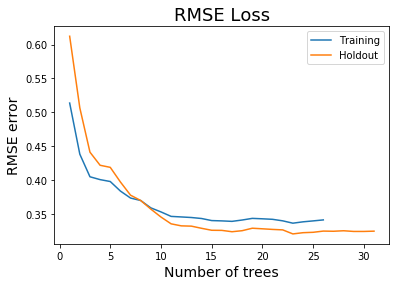

In [26]:
# declare scoring histories
scoring_history_t = rf_model.score_history()
scoring_history_h = rf_model_h.score_history()
# plot the loss for train and holdout frames 
plt.plot(scoring_history_t['number_of_trees'], scoring_history_t['training_rmse']) 
plt.plot(scoring_history_h['number_of_trees'], scoring_history_h['training_rmse']) 
labels = ['Training', 'Holdout']
plt.title('RMSE Loss', fontsize=18)
plt.ylabel('RMSE error', fontsize=14)
plt.xlabel('Number of trees', fontsize=14)
plt.legend(labels, loc='best')
plt.show()

The random forest model is stable when comparing the RMSE error of the holdout and training frames. 12-14 trees seems to be the optimal number for the model, as shown in the classification error scores for the random forest model and in the plot above. 

Overall, the neural network seems to perform better when classifiying authors, and the tfidf vectors for these words, by word usage when looking at the r2 value, but the random forest has much less classification error. The neural network is also not stable and should not be used to classify authors with this data. The random forest is the better model for this dataset due to the low classification error and stability. 